# Introduction
This is a project about image **binary classification**.

There is a **labeled dataset with images** of a book open at different pages (read the `README.md` to get more information on how to download the images). Some of them are being flipped, and some of them are not.
The purpose is to build a model that predicts whether a given image shows a page being flipped or not.

A **CNN** (Convolutional Neural Network) has been created with **PyTorch**.

The preprocessing of images, training, validation and testing has been carried out using the package **PyTorchLightning**, which makes all the process much easier and replicable.

Given the amount of images, the computation can be quite expensive computationally. That is why I have used a compute instance with **GPU** in Azure to run this Notebook.

The results on the test dataset are astonishingly good. I have also used custom images with a book that is not present in the training dataset, which had kind of OK results, showing the extent of the overfitting of the model since only one book was used to train the neural network.

Finally, the model has been deployed to two **Microsoft Azure ML endpoints** and have been used to perform some predictions which, of course, are similars to the ones using the model in this Notebook. One of the endpoints is a **batch endpoint**, for which I used a compute instance with a GPU (and hence CUDA is available). The other endpoint is an **online real time endpoint**, for which I used a compute instance with only CPU (no GPU).

For deploying to the batch endpoint I have used the **Python SDK for Azure ML**.

The framework **MLFlow** has been used for logging the model to Azure ML easily, and also for deploying it to the online real time dataset. This way we show how MLFlow allows for an agnosting deployment (independent of the platform: Azure, AWS, GCP, etc.) and how much verbosity we remove with respect the native Azure ML Python SDK, which is of course much more powerful but too verbose in consequence.

# Setup

The setup of the environment can be tricky, especially in an environment that is not local as the one I am using to execute this notebook: Microsoft Azure.

In order to make it work properly, make sure you follow these 5 steps:
- Choose Compute Instance. For example, I chose a [Standard_NC4as_T4_v3](https://learn.microsoft.com/es-es/azure/virtual-machines/nct4-v3-series) with [GPU - 1 x NVIDIA Tesla T4](https://www.nvidia.com/en-us/data-center/tesla-t4/).
- Install Poetry globally
- Create Conda virtual environment
- Add it as Jupyter Kernel
- Install necessary packages
The last 4 points can be summarized in the next script:

```bash
ENV_NAME=flippageenv

conda deactivate
conda env remove --name $ENV_NAME
conda create -n $ENV_NAME python=3.9 --yes
conda activate $ENV_NAME
conda install -c anaconda ipykernel --yes
python -m ipykernel install --user --name=$ENV_NAME

curl -sSL https://install.python-poetry.org | POETRY_HOME=~/poetry python3 -
export PATH="/home/azureuser/poetry/bin:$PATH"
poetry install
pip install torch torchvision
```

Pay attention to the fact that the Python version must not be higher than 3.9 (at least it does not work at date 2023-08-10) and that `torch` and `torchvision` packages is more convenient to install them with `pip` instead of poetry because it will automatically install additional packages to work with the GPU (CUDA).

After that, open the notebook and select the kernel named `flippageenv`.

# Imports

In [1]:
from enum import Enum
from pathlib import Path
import shutil
from typing import List, Tuple

from azure.ai.ml import constants, entities, Input, MLClient
from azure.ai.ml.entities import ManagedOnlineDeployment, Model
from azureml.core import Workspace
from azure.identity import DefaultAzureCredential
from azure.mgmt.storage import StorageManagementClient
import mlflow
from mlflow.deployments import get_deploy_client
from mlflow.models.signature import infer_signature, ModelSignature
from mlflow.types.schema import Schema, TensorSpec
from pytorch_lightning.loggers import MLFlowLogger
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import pytorch_lightning as pl
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from sklearn.metrics import ConfusionMatrixDisplay
import time
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchmetrics
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as torch_transforms
from torchvision.transforms import Lambda


pyo.init_notebook_mode()

In [2]:
class Environment(Enum):
    LOCAL = "LOCAL"
    AZURE = "AZURE"
    GOOGLE_COLABORATORY = "GOOGLE_COLABORATORY"
    
    
def get_environment() -> Environment:    
    if "AzureCloud" == os.getenv("AML_CloudName"):
        return Environment.AZURE
    
    if os.getenv("COLAB_GPU") is not None:
        return Environment.GOOGLE_COLABORATORY
    
    return Environment.LOCAL
        
    
dataloader_num_workers_map = {
    Environment.LOCAL: 0,
    Environment.AZURE: 4,
    Environment.GOOGLE_COLABORATORY: 1,
}

environment = get_environment()
dataloader_num_workers = dataloader_num_workers_map[environment]

if environment == Environment.AZURE:
    IMAGES_PATH = Path("images/project_4_monreader/images")
else:
    IMAGES_PATH = Path("images")
    
ml_client = MLClient.from_config(credential=DefaultAzureCredential())


Found the config file in: /config.json


# Dataset exploration

There are two directories, one for training data and one for testing data:

In [3]:
print(list(IMAGES_PATH.iterdir()))

[PosixPath('images/project_4_monreader/images/testing'), PosixPath('images/project_4_monreader/images/training')]


Each directory has two folders, one for pages being flipped and another one for static pages:

In [4]:
print(list((IMAGES_PATH / "training").glob("*")))
print(list((IMAGES_PATH / "testing").glob("*")))

[PosixPath('images/project_4_monreader/images/training/flip'), PosixPath('images/project_4_monreader/images/training/notflip')]
[PosixPath('images/project_4_monreader/images/testing/flip'), PosixPath('images/project_4_monreader/images/testing/notflip')]


In [5]:
number_training_flip = len(list((IMAGES_PATH / "training/flip").iterdir()))
number_training_not_flip = len(list((IMAGES_PATH / "training/notflip").iterdir()))
number_testing_flip = len(list((IMAGES_PATH / "testing/flip").iterdir()))
number_testing_not_flip = len(list((IMAGES_PATH / "testing/notflip").iterdir()))

print(f'Num training images flip: {number_training_flip}')
print(f'Num training images not flip: {number_training_not_flip}')
print(f'Num testing images flip: {number_testing_flip}')
print(f'Num testing images not flip: {number_testing_not_flip}')

Num training images flip: 1162
Num training images not flip: 1230
Num testing images flip: 290
Num testing images not flip: 307


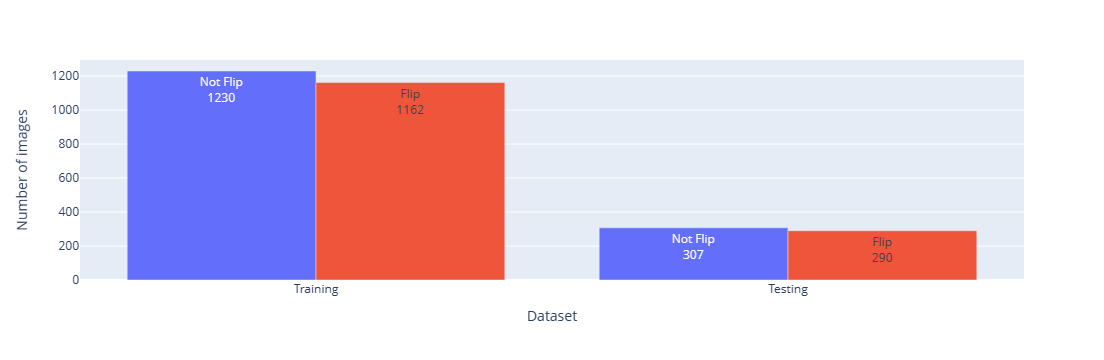

In [6]:
df = pd.DataFrame([
    ("Training", False, number_training_not_flip),
    ("Training", True, number_training_flip),
    ("Testing", False, number_testing_not_flip),
    ("Testing", True, number_testing_flip),
], columns=["Dataset", "Flip", "Number of images"])


fig = px.bar(df, x="Dataset", y="Number of images", color="Flip", text=df.Flip.map(lambda flip: "Flip" if flip else "Not Flip"), barmode="group")
fig.update_traces(texttemplate="%{text}<br>%{y}")
fig.update_layout(showlegend=False)

An example of picture is this:

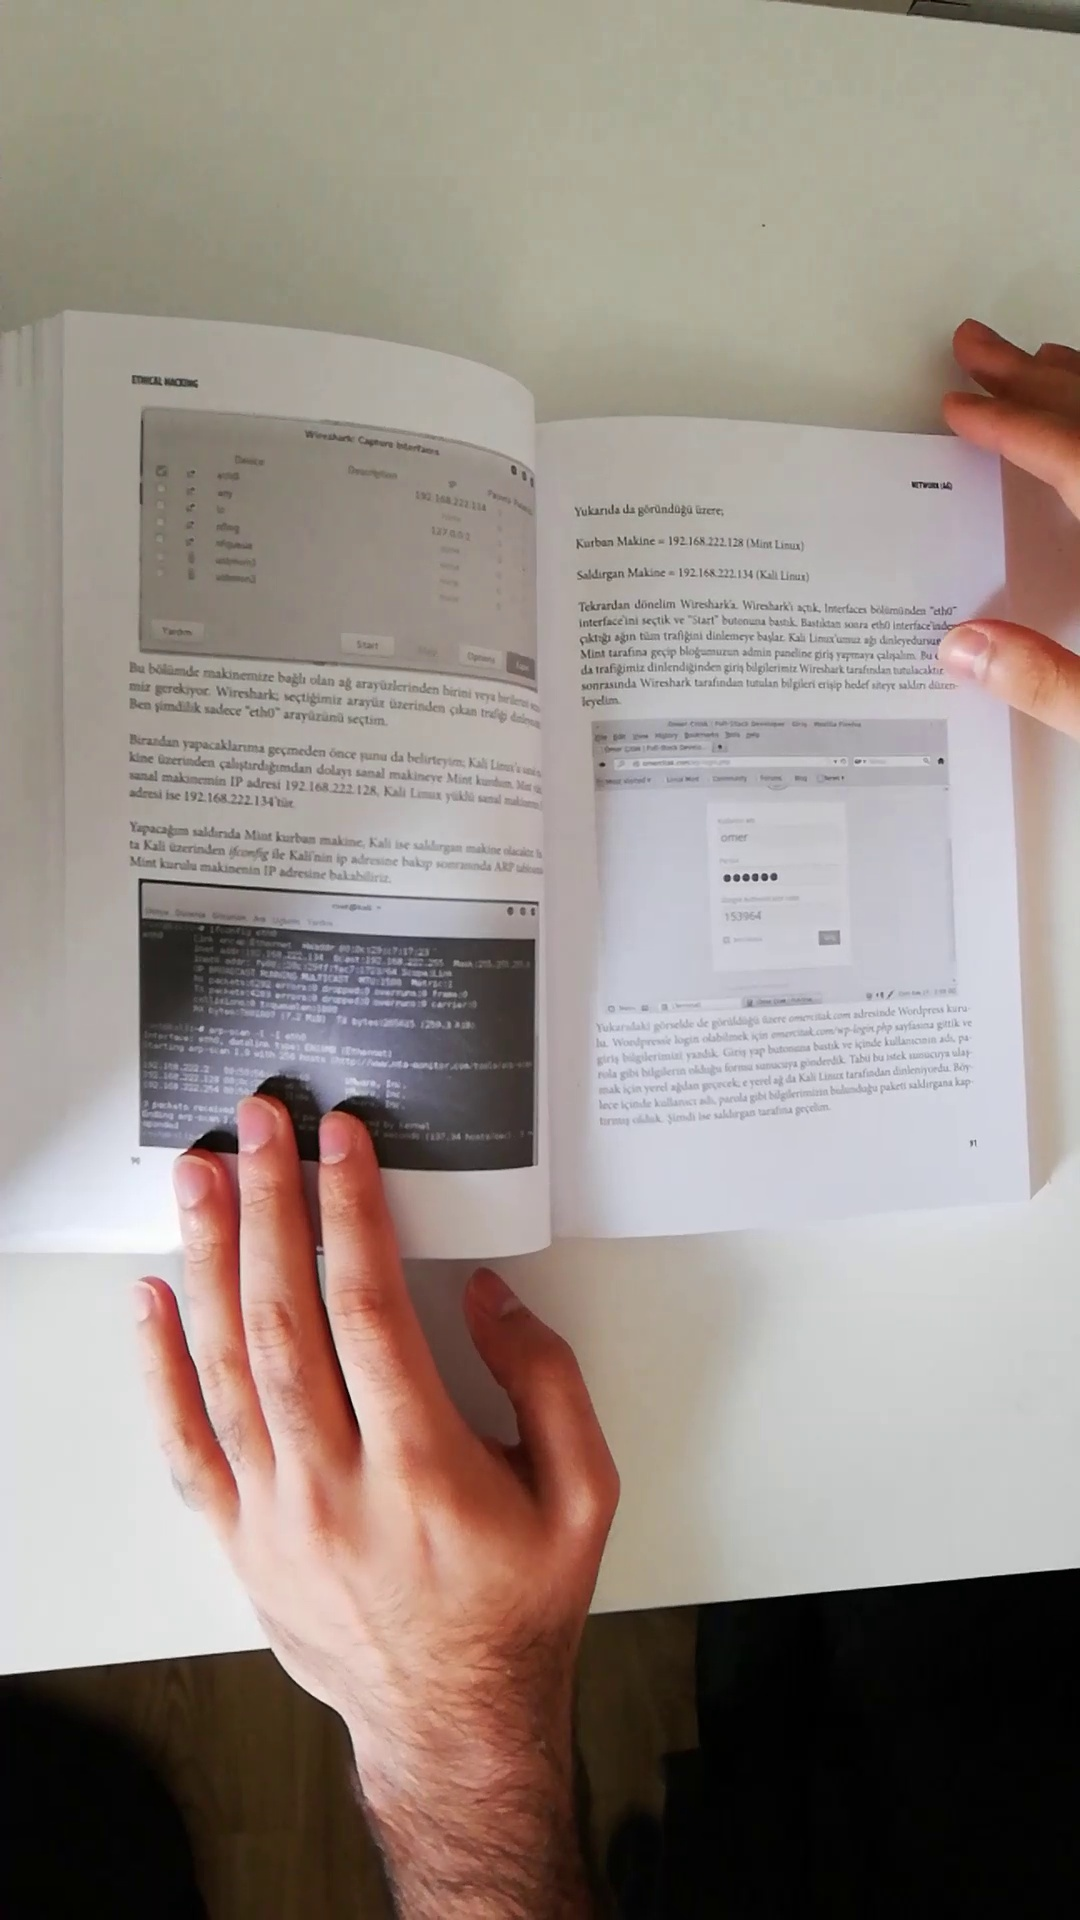

In [7]:
from IPython.display import Image

image_path = (IMAGES_PATH / "training/notflip/0002_000000009.jpg")
pil_image = Image(filename=image_path)
pil_image

# Preprocessing

## Cropping and resizing

Images can be cropped to remove non-useful information.
In the next cell one can modify the crop_bounding_box in order to see how a random batch of 16 images would appear after the cropping and resizing.

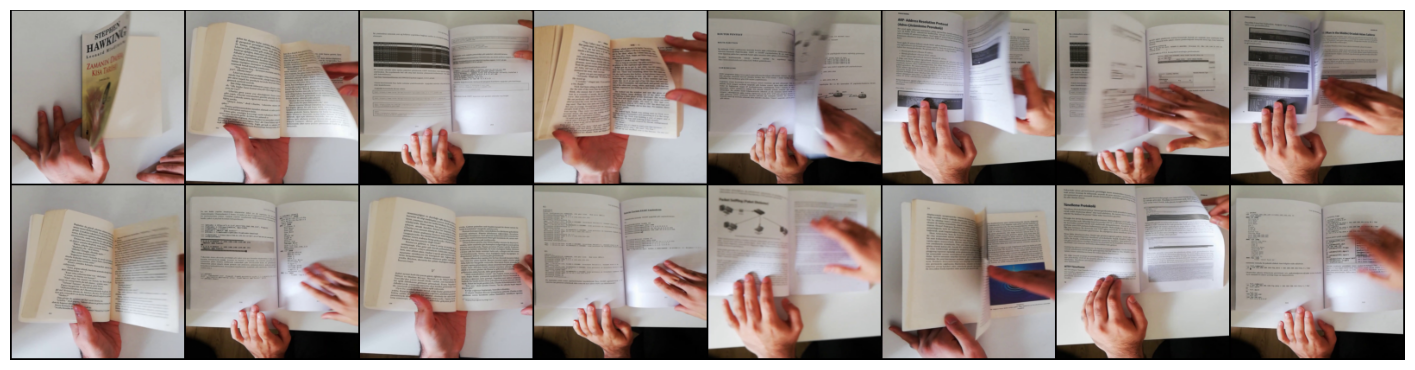

In [8]:
def display_image(image: Tensor):
    reverse_transform = torch_transforms.Compose([torch_transforms.ToPILImage()])
    image_pil = reverse_transform(image)

    px = 1 / plt.rcParams['figure.dpi']
    plt.figure(figsize=(1800*px, 1000*px))
    plt.imshow(image_pil)
    plt.axis("off")
    plt.show()
    
    
def show_batch_after_transforms(image_folder, transform, batch_size):
    dataset = ImageFolder(root=image_folder, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    images, labels = next(iter(data_loader))
    grid = torchvision.utils.make_grid(images)
    display_image(grid)
    

def Crop(top, left, height, width):
    return torch_transforms.Lambda(lambda image: torch_transforms.functional.crop(image, top, left, height, width))


WIDTH = 1080
HEIGHT = 1920

resize_to = (200, 200)
crop_bounding_box = (300, 0, HEIGHT-500, WIDTH)
transform = torch_transforms.Compose([
    Crop(*crop_bounding_box),
    torch_transforms.Resize(resize_to, antialias=True),
    torch_transforms.ToTensor(),
])
torch.manual_seed(0)

show_batch_after_transforms(IMAGES_PATH / "training", transform, 16)

After some visual examination, we see that a good cropping bounding box is one that does not remove anything from the left or right sides of the images, but removes 300 pixels from the top and 200 pixels from the bottom.

In the next cell one can preprocess the images according to some transformations and save them in numpy arrays. This can be useful in case the preprocessing of images is too heavy and we want to have it done so preprocessed images can be loaded fast into the model during training or testing.

In [9]:
# from itertools import islice

# from tqdm.notebook import tqdm


# def preprocess_images(transform, images_source_directory, images_destination_directory):
#     for dataset_source_path in tqdm(Path(images_source_directory).iterdir()):
#         dataset = ImageFolder(root=str(dataset_source_path), transform=transform)
#         dataset_destination_path = Path(images_destination_directory) / dataset_source_path.name

#         label_destination_paths = []
#         for label in dataset.classes:
#             label_destination_path = dataset_destination_path / label
#             label_destination_path.mkdir(parents=True, exist_ok=False)
#             label_destination_paths.append(label_destination_path)

#         for (image, label), (image_path, _) in tqdm(zip(dataset, dataset.samples), total=len(dataset)):
#             dest_path = label_destination_paths[label] / Path(image_path).stem
#             np.save(dest_path, image)
        
        
# data_module = DataModule(batch_size=32, resize_to=(250, 250), top_crop=300, bottom_crop=200)
# transform = data_module._get_transforms()
# preprocess_images(transform, images_source_directory="images", images_destination_directory="images_1")


# Data Loading

The load of images can be done efficiently following the Pytorch and PytorchLightning packages classes.

On the one hand, torchvision provides the class `ImageFolder`, which loads images from a folder. In our case, I have created the class `ImageFolderCustomClasses` that inherits from it, and I have overriden the `find_classes` method so we can decide which class will convert to which target value.

This will allow us to encode *flip* as 1 and *non-flip* as 0.

In [10]:
class ImageFolderCustomClasses(ImageFolder):
    def __init__(self, *args, class_to_index_mapping=None, **kwargs):
        self.class_to_index_mapping = class_to_index_mapping
        super().__init__(*args, **kwargs)
    
    def find_classes(self, directory):
        if self.class_to_index_mapping is None:
            return super().find_classes(directory)
        
        return list(self.class_to_index_mapping.keys()), self.class_to_index_mapping

Then there is PytorchLightning `LightningDataModule` class. If we inherit from it and override some basic methods to define how to load batches of images, then the package will handle the rest of the complexities of model training and evaluation.

In [11]:
class DataModule(pl.LightningDataModule):

    def __init__(self, batch_size, resize_to, top_crop, bottom_crop, train_directory="images/training", test_directory="images/testing"):
        super().__init__()
        self.batch_size = batch_size
        self.resize_to = resize_to
        self.top_crop = top_crop
        self.bottom_crop = bottom_crop
        self.train_directory = train_directory
        self.test_directory = test_directory
    
    def prepare_data(self):
        transform = self._get_transforms()
        dataset_training = ImageFolderCustomClasses(root=self.train_directory, transform=transform, class_to_index_mapping=dict(flip=1, notflip=0))
        
        self.dataset_training, self.dataset_validation = random_split(dataset_training, [0.8, 0.2], generator=torch.Generator().manual_seed(0))
        self.dataset_test = ImageFolderCustomClasses(root=self.test_directory, transform=transform, class_to_index_mapping=dict(flip=1, notflip=0))
        
    def _get_transforms(self):
        def Crop(top, left, height, width):
            return torch_transforms.Lambda(lambda image: torch_transforms.functional.crop(image, top, left, height, width))
        
        WIDTH = 1080
        HEIGHT = 1920

        crop_bounding_box = (self.top_crop, 0, HEIGHT - (self.top_crop + self.bottom_crop), WIDTH)
        return torch_transforms.Compose([
            Crop(*crop_bounding_box),
            torch_transforms.Resize(self.resize_to, antialias=True),
            torch_transforms.ToTensor(),
        ])

    def train_dataloader(self):
        return DataLoader(self.dataset_training, batch_size=self.batch_size, shuffle=True, num_workers=dataloader_num_workers)

    def val_dataloader(self):
        return DataLoader(self.dataset_validation, batch_size=self.batch_size, num_workers=dataloader_num_workers)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size, num_workers=dataloader_num_workers)

In the same way we have done for images, we can do it for preprocessed images that are saved as numpy arrays. The schema is the same:

In [12]:
from torch.utils.data import Dataset
from torchvision.datasets.folder import DatasetFolder
    
    
class NumpyDataset(DatasetFolder):
    def __init__(
        self,
        root: str,
        class_to_index_mapping=None
    ):
        self.class_to_index_mapping = class_to_index_mapping
        super().__init__(
            root,
            loader=np.load,
            extensions=[".npy"],
        )
        
    def find_classes(self, directory):
        if self.class_to_index_mapping is None:
            return super().find_classes(directory)
        
        return list(self.class_to_index_mapping.keys()), self.class_to_index_mapping
    
    
class NumpyDataModule(pl.LightningDataModule):

    def __init__(self, batch_size, train_directory, test_directory):
        super().__init__()
        self.batch_size = batch_size
        self.train_directory = train_directory
        self.test_directory = test_directory
    
    def prepare_data(self):
        dataset_training = NumpyDataset(self.train_directory, class_to_index_mapping=dict(flip=1, notflip=0))
        self.dataset_training, self.dataset_validation = random_split(dataset_training, [0.8, 0.2], generator=torch.Generator().manual_seed(0))
        self.dataset_test = NumpyDataset(self.test_directory, class_to_index_mapping=dict(flip=1, notflip=0))

    def train_dataloader(self):
        return DataLoader(self.dataset_training, batch_size=self.batch_size, shuffle=True, num_workers=dataloader_num_workers)

    def val_dataloader(self):
        return DataLoader(self.dataset_validation, batch_size=self.batch_size, num_workers=dataloader_num_workers)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size, num_workers=dataloader_num_workers)

# Model definition

The model we are going to use is a classical CNN, inspired in this [article](https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/).

In [13]:
class Stage(Enum):
    TRAIN = "TRAIN"
    VALIDATION = "VALIDATION"
    TEST = "TEST"


class FlipPageDetector(pl.LightningModule):
    def __init__(self, input_size=(32, 32)):
        super().__init__()
        self.input_size = input_size
        self._create_layers(input_size)
        self._prepare_metrics()
        
    def setup(self, stage=None):
        self.logger.log_hyperparams({"input_size": self.input_size})
        
    def _create_layers(self, input_size):
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        pool_kernel_size = (2, 2)
        self.pool2 = nn.MaxPool2d(kernel_size=pool_kernel_size)
 
        self.flat = nn.Flatten()

        num_coeffs = int(32 * input_size[0] * input_size[1] / (pool_kernel_size[0] * pool_kernel_size[1]))
        self.fc3 = nn.Linear(num_coeffs, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, 1)
    
    def _prepare_metrics(self):
        self.precision = torchmetrics.Precision(task='binary')
        self.recall = torchmetrics.Recall(task='binary')
        self.f1 = torchmetrics.F1Score(task='binary')
        self.confmat = torchmetrics.ConfusionMatrix(task="binary")

        self.targets_scores = {}
        self.targets_predicted = {}
        self.targets = {}
        
        self._reset_target_registries(Stage.TRAIN)
        self._reset_target_registries(Stage.VALIDATION)
        self._reset_target_registries(Stage.TEST)
        
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        x = self.fc4(x)
        return x
    
    def criterion(self, logits, labels):
        return nn.functional.binary_cross_entropy_with_logits(logits, torch.unsqueeze(labels.float(), 1))
    
    def training_step(self, batch, batch_index):
        return self._step(batch, Stage.TRAIN)

    def validation_step(self, batch, batch_index):
        return self._step(batch, Stage.VALIDATION)
        
    def test_step(self, batch, batch_index):
        return self._step(batch, Stage.TEST)
    
    def predict_step(self, batch, batch_idx):
        return self(batch)
    
    def on_train_epoch_start(self):
        self._reset_target_registries(Stage.TRAIN)
    
    def on_train_epoch_end(self):
        self._log_epoch_metrics(Stage.TRAIN)
    
    def on_validation_epoch_start(self):
        self._reset_target_registries(Stage.VALIDATION)
    
    def on_validation_epoch_end(self):
        self._log_epoch_metrics(Stage.VALIDATION)
    
    def on_test_epoch_start(self):
        self._reset_target_registries(Stage.TEST)
    
    def on_test_epoch_end(self):
        self._log_epoch_metrics(Stage.TEST)
                                
    def _reset_target_registries(self, stage: Stage):
        self.targets_scores[stage] = []
        self.targets_predicted[stage] = []
        self.targets[stage] = []

    def _step(self, batch, stage: Stage):
        images, targets = batch
        logits, targets_predicted = self._predict(images)

        self.targets_scores[stage].append(logits)
        self.targets_predicted[stage].append(targets_predicted)
        self.targets[stage].append(targets)
        
        loss = self.criterion(logits, targets)
        
        metric_name = {
            stage.TRAIN: "train_loss",
            stage.VALIDATION: "val_loss",
            stage.TEST: "test_loss",
        }
        
        self.log(metric_name[stage], loss, prog_bar=True)
        return loss
        
    def _predict(self, images):
        logits = self.forward(images)
        targets_predicted_proba = torch.sigmoid(logits)
        targets_predicted = targets_predicted_proba.round().int()
        
        return logits, targets_predicted
        
    def _log_epoch_metrics(self, stage: Stage):
        targets_predicted = torch.cat(self.targets_predicted[stage], dim=0).squeeze()
        targets = torch.cat(self.targets[stage], dim=0)

        precision = self.precision(targets_predicted, targets)
        recall = self.recall(targets_predicted, targets)
        f1_score = self.f1(targets_predicted, targets)

        self.log(f'{stage.value}_precision', precision, prog_bar=True)
        self.log(f'{stage.value}_recall', recall, prog_bar=True)
        self.log(f'{stage.value}_f1', f1_score, prog_bar=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def get_targets(self, stage: Stage):
        return torch.cat(self.targets[stage], dim=0).to(torch.device("cpu"))
    
    def get_targets_scores(self, stage: Stage):
        return torch.cat(self.targets_scores[stage], dim=0).squeeze().to(torch.device("cpu"))
    
    def get_targets_predicted(self, stage: Stage):
        return torch.cat(self.targets_predicted[stage], 0).squeeze().to(torch.device("cpu"))
        
        
class FlipPageDetectorProduction(FlipPageDetector):
    def forward(self, image_azure_format):
        image = torch.Tensor(image_azure_format).permute(2, 0, 1).unsqueeze(0).cuda() / 255.0
        return super().forward(image)
    
    
class FlipPageDetectorProductionNoCuda(FlipPageDetector):
    def forward(self, image_azure_format):
        image = torch.Tensor(image_azure_format).permute(2, 0, 1).unsqueeze(0) / 255.0
        return super().forward(image)
    

Pay attention to the last classes `FlipPageDetectorProduction` and `FlipPageDetectorProductionNoCuda`. This classes are created for deploying the model to a batch endpoint in Azure ML. Why don't we just deploy the model as is? The problem with that approach is that our model expects the input images as PyTorch tensors with dimensions (num_images, 3, 250, 250) and float values (original uint8 values divided by 255) because it is how it has been trained.

However, in Azure endpoints, the images will be loaded individually with dimensions (250, 250, 3) and values won't be normalized. That is why we need this wrapper around the original forward function in order to adjust the image format and produce similar results.

The reason we have two classes for production is that one of them will work with CUDA in instances with a GPU (`FlipPageDetectorProduction`), and the other one will work on instances with just CPU (`FlipPageDetectorProductionNoCuda`).

# Training

Now it is time to train the images. Remember to execute this code in some machine with GPU, like an Azure compute instance with the appropriate features.

In [14]:
experiment_name = "FlipPageDetectorExperiment"
model_log_name = "FlipPageDetector"

In [16]:
def log_model(model, wrapper_class, model_log_name, input_size):
    def get_signature():
        input_schema = Schema([TensorSpec(type=np.dtype("float32"), shape=input_size + (3,))])
        output_schema = Schema([TensorSpec(type=np.dtype("int8"), shape=(-1,))])
        return ModelSignature(inputs=input_schema, outputs=output_schema)
        
    def copy_model(model, target_class):
        model_production = target_class(input_size=input_size)
        model_production.load_state_dict(model.state_dict())
        model_production.eval()
        return model_production
        
    signature = get_signature()
    model_production = copy_model(model, wrapper_class)
    mlflow.pytorch.log_model(model_production, model_log_name, signature=signature, conda_env="conda.yaml")

    
ws = Workspace.from_config()
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

input_size = (250, 250)

train_always = True
save_checkpoint = True
if train_always or not Path("model.ckpt").is_file():
    experiment = mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run() as run:
        mlogger = MLFlowLogger(experiment_name=experiment_name, run_id=run.info.run_id)

        data_module = DataModule(
            batch_size=32,
            resize_to=input_size,
            top_crop=300,
            bottom_crop=200,
            train_directory=IMAGES_PATH / "training",
            test_directory=IMAGES_PATH / "testing"
        )

        max_epochs = 10
        mlogger.log_hyperparams(dict(max_epochs=max_epochs))
        model = FlipPageDetector(input_size=input_size)
        trainer = pl.Trainer(
            max_epochs=max_epochs,
            accelerator="auto",
            log_every_n_steps=10,
            logger=mlogger,
        )

        trainer.fit(model, data_module)
        trainer.test(model, data_module)
        
        log_model(model, FlipPageDetectorProduction, model_log_name, input_size)
        log_model(model, FlipPageDetectorProductionNoCuda, f"{model_log_name}_cpu", input_size)
        
        if save_checkpoint:
            trainer.save_checkpoint("model.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type                  | Params
-----------------------------------------------------
0  | conv1     | Conv2d                | 896   
1  | act1      | ReLU                  | 0     
2  | drop1     | Dropout               | 0     
3  | conv2     | Conv2d                | 9.2 K 
4  | act2      | ReLU                  | 0     
5  | pool2     | MaxPool2d             | 0     
6  | flat      | Flatten               | 0     
7  | fc3       | Linear                | 256 M 
8  | act3      | ReLU                  | 0     
9  | drop3     | Dropout               | 0     
10 | fc4       | Linear                | 513   
11 | precision | BinaryPrecision       | 0     
12 | recall    | BinaryRecall          | 0     
13 | f1        | BinaryF1Score         | 0     
14 | confmat   | BinaryConfusio

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         TEST_f1            0.9811320900917053
     TEST_precision         0.9761092066764832
       TEST_recall          0.9862068891525269
        test_loss           0.05390549823641777
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/anaconda/envs/flippageenv/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning:

Setuptools is replacing distutils.



# Load model

In case you want to reload a saved model, execute next cells

In [18]:
load_from_checkpoint = False
if load_from_checkpoint:
    model = FlipPageDetector.load_from_checkpoint(checkpoint_path="model.ckpt", input_size=(250, 250))

# Evaluation

Here we evaluate the model performance on the validation and test sets. After 10 epochs of training we see the performance is very good.

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay


prediction_metric_functions = dict(
    recall=torchmetrics.functional.recall,
    precision=torchmetrics.functional.precision,
    f1=torchmetrics.functional.f1_score,
    acc=torchmetrics.functional.accuracy,
)


score_metric_functions = dict(
    roc_auc=torchmetrics.AUROC(task="binary"),
)


def get_metrics(model, stage: Stage, threshold=0.5) -> pd.Series:
    targets = model.get_targets(stage)
    targets_scores = model.get_targets_scores(stage)
    # targets_predicted = model.get_targets_predicted(stage)
    
    prediction_metrics = {
        metric: function(preds=targets_scores, target=targets, task="binary", threshold=threshold)
        for metric, function in prediction_metric_functions.items()
    }
    
    score_metrics = {
        metric: function(targets_scores, targets)
        for metric, function in score_metric_functions.items()
    }
    
    return pd.Series(prediction_metrics | score_metrics)


def plot_metrics(model, stage: Stage, threshold=0.5):
    metrics = get_metrics(model, stage, threshold)
    return go.Figure(
        data=go.Bar(x=metrics.index, y=metrics),
        layout_title=f"Threshold: {threshold}"
    )


def plot_confusion_matrix(model, stage: Stage, threshold=0.5):
    targets = model.get_targets(stage)
    targets_scores = model.get_targets_scores(stage)
    # targets_predicted = targets_scores > 0#model.get_targets_predicted(stage)
    cm = torchmetrics.ConfusionMatrix(task="binary", threshold=threshold)(targets_scores, targets).numpy()
    
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()


def draw_roc(model, stage: Stage, threshold=0.5):
    targets = model.get_targets(stage)
    targets_scores = model.get_targets_scores(stage)
    
    fpr, tpr, thresholds = torchmetrics.ROC(task="binary", threshold=threshold)(targets_scores, targets)
    
    index = np.argmin(abs(thresholds - threshold))
    
    return go.Figure(
        data=[
            go.Scatter(x=fpr, y=tpr),
            go.Scatter(x=[fpr[index]], y=[tpr[index]], showlegend=False, mode="markers+text", text=f"Threshold = {threshold}", textposition="middle right")
        ],
        layout=dict(
            height=500,
            width=500,
            xaxis_title="False positive rate",
            yaxis_title="True positive rate",
            title="ROC"
        )
    )

In [20]:
data_module = DataModule(
    batch_size=32,
    resize_to=(250, 250),
    top_crop=300,
    bottom_crop=200,
    train_directory=IMAGES_PATH / "training",
    test_directory=IMAGES_PATH / "testing"
)

model.eval()
trainer = pl.Trainer()
trainer.validate(model, data_module)
trainer.test(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      VALIDATION_f1         0.9939637780189514
  VALIDATION_precision      0.9879999756813049
    VALIDATION_recall               1.0
        val_loss            0.03393135964870453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         TEST_f1            0.9811320900917053
     TEST_precision         0.9761092066764832
       TEST_recall          0.9862068891525269
        test_loss           0.05390549823641777
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.05390549823641777,
  'TEST_precision': 0.9761092066764832,
  'TEST_recall': 0.9862068891525269,
  'TEST_f1': 0.9811320900917053}]

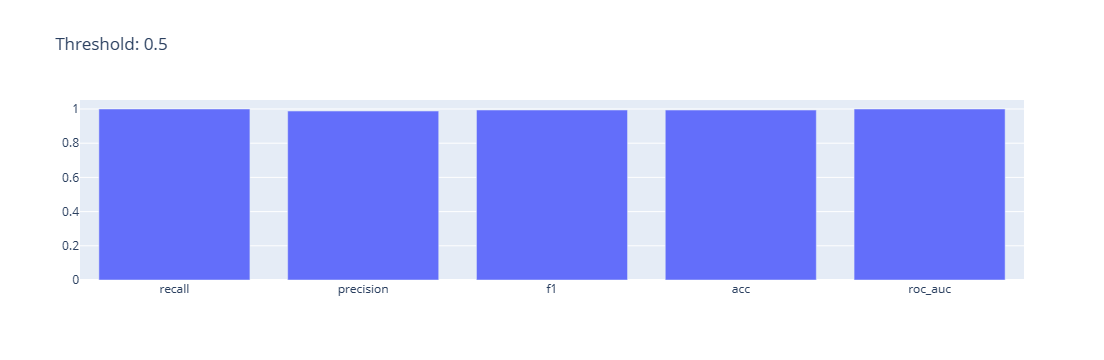

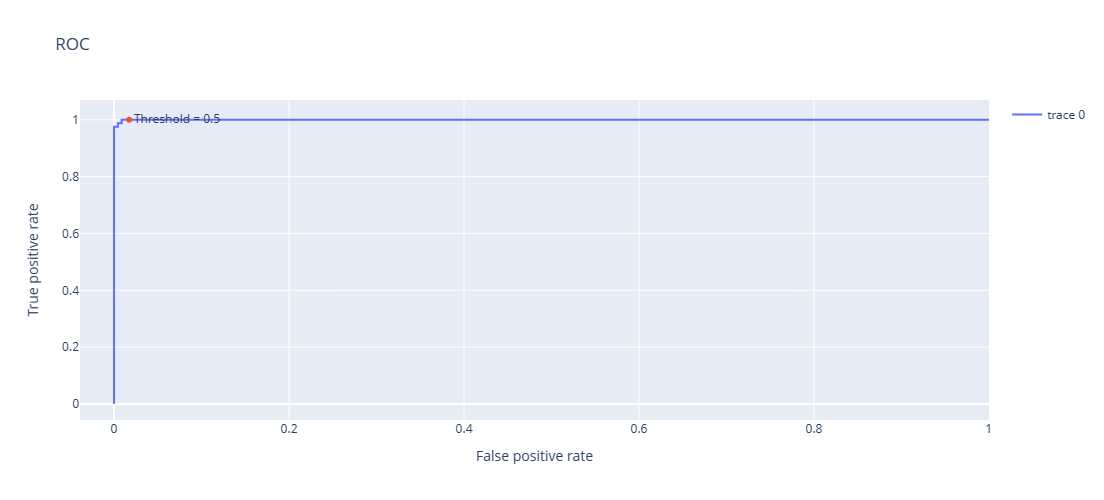

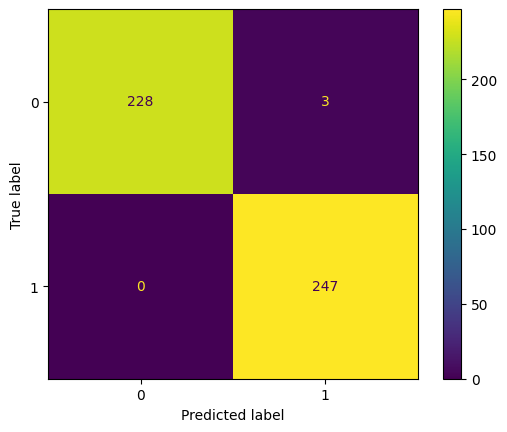

In [21]:
plot_metrics(model, Stage.VALIDATION).show()
draw_roc(model, Stage.VALIDATION).show()
plot_confusion_matrix(model, Stage.VALIDATION)

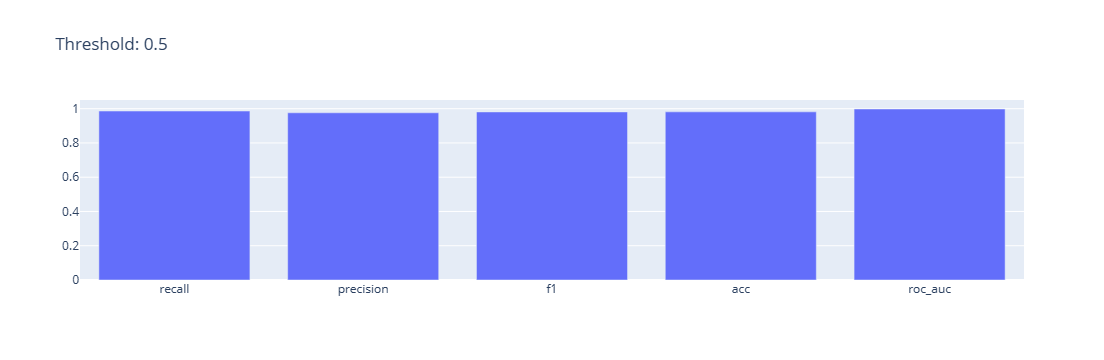

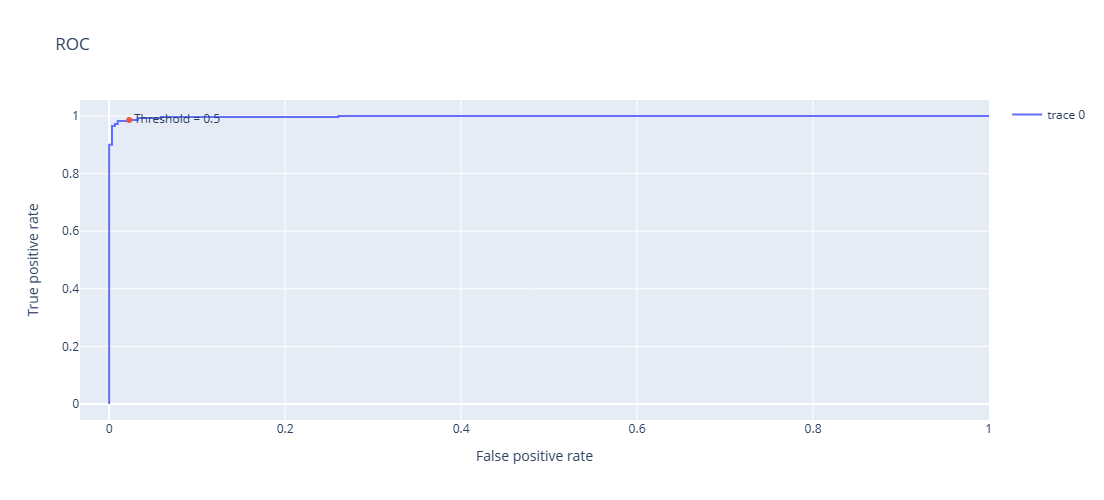

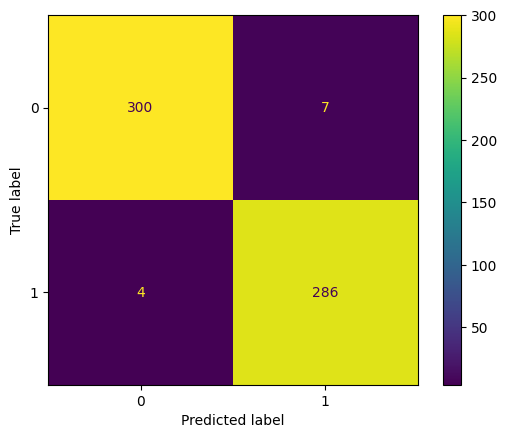

In [22]:
plot_metrics(model, Stage.TEST).show()
draw_roc(model, Stage.TEST).show()
plot_confusion_matrix(model, Stage.TEST)

We can see that with 10 epochs, the results are very good, almost perfect, with all relevant metrics above 99%.

# Detect flip in sequence of images

What if we don't want to predict individual images but sequences of them? Actually, that is the most realistic scenario, since these kind of images wil come from a video. In this case, we are going to use two simple approaches.

In the first approach, we will consider all images as being of the same kind (i.e. being images from a flip or a non-flip). Then we will compute the likelihood of the whole sequence in one case or the other.

That first approach is somewhat unrealistic (see below to understand why), so we will explore a second and simpler approach that just predicts a flip if at least one of the images is considered a flip. Despite the simplicity of the algorithm, it is highly effective.

First let's create a dataset that takes sequences of images instead of individual images:

In [23]:
class ImageSequenceDataset(ImageFolderCustomClasses):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        images, _ = zip(*self.samples)
        self.sequence_ids = set(
            re.search(r"(?P<id>\w+/\d{4})_.+.jpg", image).group("id")
            for image in images
        )
                
    def __len__(self):
        return len(self.sequence_ids)
    
    def __iter__(self):
        for sequence_id in self.sequence_ids:
            yield self[sequence_id]
    
    def __getitem__(self, index: str):
        images_indices = [
            i
            for i, (sample, target) in enumerate(self.samples)
            if index in str(sample)
        ]
        
        target = self.samples[images_indices[0]][1]
        
        return torch.stack([
            super(ImageSequenceDataset, self).__getitem__(index)[0]
            for index in images_indices
        ]), target
            
        
sequence_dataset = ImageSequenceDataset(IMAGES_PATH / "testing", transform=data_module._get_transforms(), class_to_index_mapping=dict(flip=1, notflip=0))

In order to detect if a page is being flip in a series of video frames, we can just make a prediction for each image separatedly and then predict a flip if most of them are predicted as being flipped.

Actually, as we got the value of the logits, we can predict a flipping sequence if the sum of the logits is bigger than 0 and non-flip otherwise. This makes sense because it is like computing the likelihood of the full sequence.

In [24]:
def predict_sequence(sequence_index):
    sequence, target = sequence_dataset[sequence_index]
    logits = model(sequence).detach().numpy()
    return logits.sum()
    
    
print("Sum of logits for different sequences")

print(f'Notflip: {predict_sequence("/notflip/0001")}')
print(f'Notflip: {predict_sequence("/notflip/0002")}')
print(f'Notflip: {predict_sequence("/notflip/0003")}')
print(f'Notflip: {predict_sequence("/notflip/0004")}')
print(f'Notflip: {predict_sequence("/notflip/0005")}')

print(f'Flip: {predict_sequence("/flip/0001")}')
print(f'Flip: {predict_sequence("/flip/0002")}')
print(f'Flip: {predict_sequence("/flip/0003")}')
print(f'Flip: {predict_sequence("/flip/0004")}')
print(f'Flip: {predict_sequence("/flip/0005")}')


Sum of logits for different sequences
Notflip: -86.57579803466797
Notflip: -125.87445068359375
Notflip: -46.24448776245117
Notflip: -122.79327392578125
Notflip: -71.33872985839844
Flip: 13.337104797363281
Flip: 3.7187891006469727
Flip: 15.884902000427246
Flip: 24.06203842163086
Flip: 20.44483757019043


However, previous approach assumes that all images on the sequence are either flip or not flip. But that assumption is useless in a realistic scenario where some of the frames will show non-flipping pages, and at some point the flipping will happen. Then, it is better to predict a flip if at least one image is predicted as a flip. In this way we will be able to process sequences in which there is a mix of cases:

In [25]:
predictions = []
targets = []
for i, (sequence, target) in enumerate(sequence_dataset):
    print(f"{i}/{len(sequence_dataset)}", end="\r")
    logits = model(sequence).detach().numpy()
    prediction = any(logits > 0)
    predictions.append(prediction)
    targets.append(target)

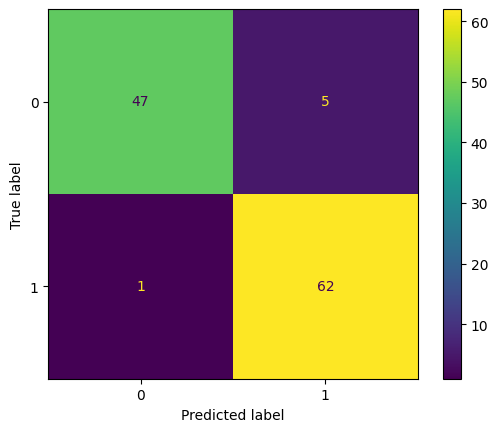

In [26]:
cm = torchmetrics.ConfusionMatrix(task="binary")(torch.Tensor(predictions), torch.Tensor(targets)).numpy()
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

As we can see, the performance is almost perfect for sequences of images too.

# Custom images

What if we try the model over images of myself flipping or not flipping pages of one of my books? Will the model be able to generalize correctly or is has been completely overfitted to the available dataset?

As you will see, the model does kind of an OK job. Its predictions are not accurate, but they are not totally wrong, which can be surprising since the training dataset only contains images from the same book, the same lightning, etc., and still is able to get a sense of whether or not I am flipping images or not.

In [27]:
class ImageFolderRoot(ImageFolder):
    @staticmethod
    def make_dataset(
        directory: str,
        *_,
        **__
    ) -> List[Tuple[str, int]]:
        return [(path, 0) for path in Path(directory).iterdir()]
    
    def find_classes(self, directory: str):
        return [], {}
    
    def __getitem__(self, index: int):
        return super().__getitem__(index)[0]
    
    
transform = torch_transforms.Compose([
    torch_transforms.Resize((250, 250), antialias=True),
    torch_transforms.ToTensor(),
])

In [28]:
predictions_custom_images = []
for image in ImageFolderRoot("images/custom", transform=transform):
    predictions_custom_images.append(model(image.unsqueeze(0)).item())

In [29]:
predictions_custom_images

[8.103310585021973,
 6.640188217163086,
 13.703465461730957,
 20.59311866760254,
 20.35833168029785]

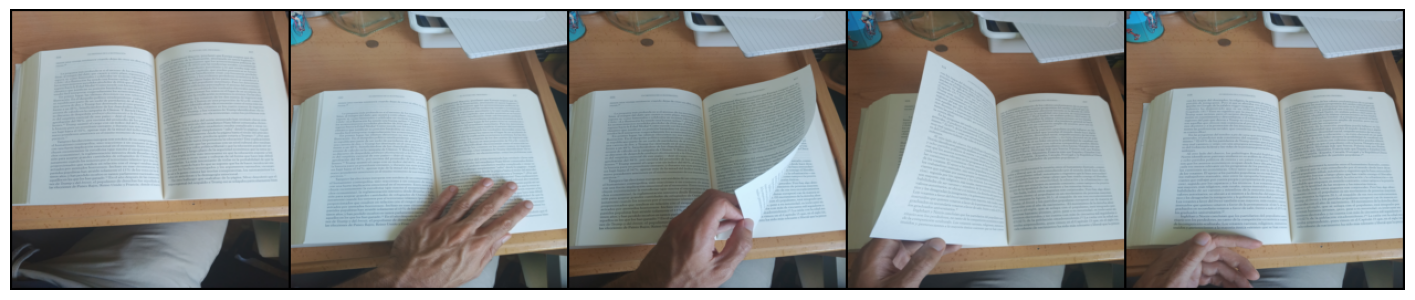

In [30]:
def display_image(image: Tensor):
    reverse_transform = torch_transforms.Compose([torch_transforms.ToPILImage()])
    image_pil = reverse_transform(image)

    px = 1 / plt.rcParams['figure.dpi']
    plt.figure(figsize=(1800*px, 1000*px))
    plt.imshow(image_pil)
    plt.axis("off")
    plt.show()

    
batch = next(iter(DataLoader(ImageFolderRoot("images/custom", transform=transform), batch_size=5, shuffle=False)))
grid = torchvision.utils.make_grid(batch)
display_image(grid)

We can see that even if the predictions are all positive, the values are higher for those images where the page is indeed being flipped. This means that adjusting the threshold we could potentially get good predictions, although for a robust generalization we would need to include similar images in the training dataset.

The used dataset only includes images of the same hand and the same book, which of course does not allow for a lot of generalization, i.e. it is very easy to overfit.

# Deploy model to Azure ML

## Deploy to batch endpoint

Now it is time to deploy the model to a Microsoft Azure ML batch endpoint.

We will
- create a compute instance
- create the endpoint
- register the model
- deploy the model

Don't get focused on the exact process, because there are many possible configurations and it is likely that the Azure API will change in a future. But, for sure, get inspired and try to understand the process because all cloud platforms are conceptually similar.

In [31]:
def get_workspace_storage_account_name(workspace):
    datastore = workspace.get_default_datastore()
    return datastore.account_name


def get_storage_account_virtual_network_parameters(resource_group_name, storage_account_name):
    credential = DefaultAzureCredential()
    subscription_id = ws.subscription_id
    storage_client = StorageManagementClient(credential, subscription_id)
    
    storage_account_properties = storage_client.storage_accounts.get_properties(resource_group_name, storage_account_name)
    
    virtual_network_resource_id = storage_account_properties.network_rule_set.virtual_network_rules[0].virtual_network_resource_id
    return Path(virtual_network_resource_id).parts[-3], Path(virtual_network_resource_id).parts[-1]


def get_workspace_storage_account_virtual_network_parameters(workspace):
    storage_account = get_workspace_storage_account_name(workspace)
    return get_storage_account_virtual_network_parameters(workspace.resource_group, storage_account)


def create_compute_cluster(compute_name, virtual_network, subnet):
    if not any(filter(lambda m: m.name == compute_name, ml_client.compute.list())):
        compute_cluster = entities.AmlCompute(
            name=compute_name,
            description="CPU cluster compute",
            min_instances=0,
            max_instances=2,
            network_settings=entities.NetworkSettings(vnet_name=virtual_network, subnet=subnet),
            size="Standard_NC6s_v3",
        )
        ml_client.compute.begin_create_or_update(compute_cluster).result()
        

def register_last_run_model(experiment_name, model_log_name, model_registry_name):
    experiment = mlflow.get_experiment_by_name(experiment_name)
    last_run_id = mlflow.search_runs(experiment_ids=experiment.experiment_id).iloc[-1].run_id
    run_id = last_run_id
    run_model_uri = f"runs:/{run_id}/{model_log_name}"

    model_details = mlflow.register_model(run_model_uri, model_registry_name)
    return model_details
    

def deploy_model_to_endpoint(endpoint_name, deployment_name, compute_name, model_name, model_version):
    model = ml_client.models.get(model_name, model_version)

    deployment = entities.ModelBatchDeployment(
        name=deployment_name,
        endpoint_name=endpoint_name,
        model=model,
        compute=compute_name,
        settings=entities.ModelBatchDeploymentSettings(
            instance_count=2,
            max_concurrency_per_instance=2,
            mini_batch_size=10,
            output_action=constants.BatchDeploymentOutputAction.APPEND_ROW,
            output_file_name="predictions.csv",
            retry_settings=entities.BatchRetrySettings(max_retries=3, timeout=300),
            logging_level="info",
        ),
    )

    ml_client.batch_deployments.begin_create_or_update(deployment).result()

    endpoint = ml_client.batch_endpoints.get(endpoint_name)
    endpoint.defaults.deployment_name = deployment.name
    ml_client.batch_endpoints.begin_create_or_update(endpoint).result()

    
def create_batch_endpoint(**kwargs):
        endpoint = entities.BatchEndpoint(**kwargs)
        ml_client.batch_endpoints.begin_create_or_update(endpoint).result()
        return ml_client.batch_endpoints.get(endpoint.name)

In [32]:
compute_name = "batch-cluster-flip-page-detector"
batch_endpoint_name = "flip-page-batch-endpoint"
model_registry_name = "FlipPageDetector"

register_last_run_model(experiment_name, model_log_name, model_registry_name)
registered_model = ml_client.models.get(name=model_registry_name, label="latest")    
virtual_network, subnet = get_workspace_storage_account_virtual_network_parameters(ws)
create_compute_cluster(compute_name, virtual_network, subnet)
endpoint = create_batch_endpoint(name=batch_endpoint_name, description="A test batch endpoint")
    
deploy_model_to_endpoint(
    endpoint_name=endpoint.name,
    deployment_name="batch-deployment",
    compute_name=compute_name,
    model_name=registered_model.name,
    model_version=registered_model.version
)

Registered model 'FlipPageDetector' already exists. Creating a new version of this model...
2023/08/12 13:18:39 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: FlipPageDetector, version 11
Created version '11' of model 'FlipPageDetector'.
Class ModelBatchDeploymentSettings: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ModelBatchDeployment: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


## Deploy to online endpoint

Here we are going to try the other option for model deployment in Azure ML: an online real time endpoint.

While batch endpoints are great for processing huge amounts of data, they are not intended for real time applications. Online endpoints, on the other hand, work with very low latency, allowing for real time applications.

In this case we are going to use an instance without a GPU (unlike in the batch endpoint). This will reduce costs, since online endpoints must be available all the time and expensive instances can be very expensive in the long run.

The model we will use is similar to that of the batch endpoint, but instead of converting de input tensor to CUDA device, it will keep it in the CPU.

The cool thing about this process is that we can directly use MLFlow to interact with Azure ML, so we don't even need to learn the Azure ML Python SDK.

In [39]:
def create_endpoint(deployment_client, endpoint_name):
    return deployment_client.create_endpoint(
        endpoint_name,
        config={
            "auth_mode": "key",
            "identity": {
                "type": "system_assigned"
            }
        }
    )


def deploy_model(deployment_client, endpoint_name, deployment_name, model_name, model_version):
    def create_deployment_config(config_file):
        deploy_config = {
            "instance_type": "Standard_D2as_v4",
            "instance_count": 1,
            "readiness_probe": {"timeout": 30},
        }

        Path(config_file).write_text(json.dumps(deploy_config))
    
    create_deployment_config("deployment_config.json")
    
    return deployment_client.create_deployment(
        name=deployment_name,
        model_uri=f"models:/{model_name}/{model_version}",
        endpoint=endpoint_name,
        config={'deploy-config-file': "deployment_config.json"},
    )


def assign_all_traffic_to_deployment(endpoint_name, deployment_name):
    traffic_config = {"traffic": {deployment_name: 100}}

    traffic_config_path = "traffic_config.json"
    Path(traffic_config_path).write_text(json.dumps(traffic_config))

    deployment_client.update_endpoint(
        endpoint=endpoint_name,
        config={"endpoint-config-file": traffic_config_path},
    )
    

In [40]:
model_registry_name = "FlipPageDetectorCPU"
deployment_name = "mlflow-deployment"
online_endpoint_name = "flip-image-online-endpoint"

# register_last_run_model(experiment_name, f"{model_log_name}_cpu", model_registry_name)
deployment_client = get_deploy_client(mlflow.get_tracking_uri())
registered_model = ml_client.models.get(name=model_registry_name, label="latest")
endpoint = create_endpoint(deployment_client, online_endpoint_name)
deploy_model(deployment_client, online_endpoint_name, deployment_name, registered_model.name, registered_model.version)
assign_all_traffic_to_deployment(online_endpoint_name, deployment_name)

......................................................................................................................................................

# Test endpoints

Now we execute the model we just deployed to the endpoints and check that the predictions are (obviously) the same as with the model we trained.

## Test batch endpoint

In [41]:
def create_test_examples_dataset(test_examples_folder):
    def create_test_sample(folder):
        data_module = DataModule(
            batch_size=32,
            resize_to=(250, 250),
            top_crop=300,
            bottom_crop=200,
            train_directory=IMAGES_PATH / "training",
            test_directory=IMAGES_PATH / "testing"
        )
        data_module.prepare_data()
        sample_batch, labels = next(iter(DataLoader(data_module.dataset_test, batch_size=5, shuffle=True)))

        shutil.rmtree(folder)
        Path(folder).mkdir()
        for i, image in enumerate(sample_batch):
            torchvision.utils.save_image(image, f"{folder}/image_{i}.png")
            
    create_test_sample(test_examples_folder)
        
    data_configuration = entities.Data(
        path=test_examples_folder,
        type=constants.AssetTypes.URI_FOLDER,
        description="A sample of images from test set",
        name="test_examples_dataset",
    )
    dataset = ml_client.data.create_or_update(data_configuration)
    return dataset


In [42]:
dataset = create_test_examples_dataset("images/test_examples")
data_input = Input(type=constants.AssetTypes.URI_FOLDER, path=dataset.id)
job = ml_client.batch_endpoints.invoke(
   endpoint_name=batch_endpoint_name,
   input=data_input,
)
ml_client.jobs.get(job.name)


Uploading test_examples (0.37 MBs): 100%|██████████| 367763/367763 [00:00<00:00, 2865893.43it/s]




PipelineJob({'inputs': {}, 'outputs': {}, 'jobs': {}, 'component': PipelineComponent({'intellectual_property': None, 'auto_increment_version': False, 'source': 'REMOTE.WORKSPACE.JOB', 'is_anonymous': True, 'auto_delete_setting': None, 'name': 'azureml_anonymous', 'description': "Attempting to create pipeline submission settings for endpoint: 'flip-page-batch-endpoint', deployment: 'batch-deployment'.", 'tags': {}, 'properties': {}, 'print_as_yaml': True, 'id': None, 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/rubchumegpu/code/Users/rubchume/Ec5VUAs47oPS5fIi', 'creation_context': None, 'serialize': <msrest.serialization.Serializer object at 0x7f9bd104cf10>, 'version': '1', 'latest_version': None, 'schema': None, 'type': 'pipeline', 'display_name': 'bubbly_brick_jbfqnhr2', 'is_deterministic': None, 'inputs': {}, 'outputs': {}, 'yaml_str': None, 'other_parameter': {}, 'jobs': {}, 'job_types': {}, 'job_sources': {}, 'source_job_id': None}), 'type': 'pipeline', 'status': 'Preparing', 'log_files': None, 'name': 'batchjob-2199bbb1-dd5b-408a-a018-09ba5506fa9e', 'description': "Attempting to create pipeline submission settings for endpoint: 'flip-page-batch-endpoint', deployment: 'batch-deployment'.", 'tags': {'outputType': 'output_data', 'inputType': 'input_data', 'azureml.batchrun': 'true', 'azureml.deploymentname': 'batch-deployment', 'azureml.jobtype': 'azureml.batchjob'}, 'properties': {'azureml.pipelineid': '90d55877-bb75-48f6-bcb7-9da182e575cb', 'azureml.runsource': 'azureml.PipelineRun', 'runSource': 'Unavailable', 'runType': 'HTTP', 'azureml.parameters': '{"run_max_try":"3","run_invocation_timeout":"300","mini_batch_size":"10","error_threshold":"-1","logging_level":"INFO","process_count_per_node":"2","legacy_model_job":"False","NodeCount":"1","append_row_file_name":"predictions.csv"}', 'azureml.continue_on_step_failure': 'False', 'azureml.continue_on_failed_optional_input': 'False', 'azureml.pipelineComponent': 'pipelinerun'}, 'print_as_yaml': True, 'id': '/subscriptions/c3771bb2-164a-4abc-a91d-4f2c9b4652cc/resourceGroups/defaultresourcegroup/providers/Microsoft.MachineLearningServices/workspaces/apzivaproject4monreader/jobs/batchjob-2199bbb1-dd5b-408a-a018-09ba5506fa9e', 'Resource__source_path': None, 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/rubchumegpu/code/Users/rubchume/Ec5VUAs47oPS5fIi', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7f9bd104caf0>, 'serialize': <msrest.serialization.Serializer object at 0x7f9bd1077280>, 'display_name': 'bubbly_brick_jbfqnhr2', 'experiment_name': 'flip-page-batch-endpoint', 'compute': None, 'services': {'Tracking': {'endpoint': 'azureml://westeurope.api.azureml.ms/mlflow/v1.0/subscriptions/c3771bb2-164a-4abc-a91d-4f2c9b4652cc/resourceGroups/defaultresourcegroup/providers/Microsoft.MachineLearningServices/workspaces/apzivaproject4monreader?', 'type': 'Tracking'}, 'Studio': {'endpoint': 'https://ml.azure.com/runs/batchjob-2199bbb1-dd5b-408a-a018-09ba5506fa9e?wsid=/subscriptions/c3771bb2-164a-4abc-a91d-4f2c9b4652cc/resourcegroups/defaultresourcegroup/workspaces/apzivaproject4monreader&tid=f4d1e53e-b4af-49af-a80f-55fd817818d9', 'type': 'Studio'}}, 'settings': {}, 'identity': None, 'default_code': None, 'default_environment': None})

In [43]:
init_time = time.perf_counter()
while ml_client.jobs.get(job.name).status != "Completed":
    time.sleep(5)
    print(f"Time elapsed: {time.perf_counter() - init_time} seconds", end="\r")

print("Job has completed")

Job has completed5.4610602999983 seconds


Compare endpoint predictions with local predictions

In [44]:
ml_client.jobs.download(name=job.name, output_name='score', download_path='./')

In [45]:
def parse_prediction_line(line):
    image, prediction_str = eval(line)
    prediction = eval(prediction_str)[0]
    return image, prediction


with Path("predictions.csv").open("r") as file:
    predictions_batch_endpoint = dict([parse_prediction_line(line) for line in file.readlines()])

## Test online endpoint

In [46]:
class ImageFolderRoot(ImageFolder):
    @staticmethod
    def make_dataset(
        directory: str,
        *_,
        **__
    ) -> List[Tuple[str, int]]:
        return [(path, 0) for path in Path(directory).iterdir()]
    
    def find_classes(self, directory: str):
        return [], {}
    
    def __getitem__(self, index: int):
        image = super().__getitem__(index)[0]
        return image.squeeze().permute(1, 2, 0)
    

transform = torch_transforms.Compose([
    torch_transforms.Resize((250, 250), antialias=True),
    torch_transforms.ToTensor(),
    torch_transforms.Lambda(lambda image: image * 255)
])
image_folder = ImageFolderRoot("images/test_examples", transform=transform)

predictions_online_endpoint = {}
for (image_path, _), image in zip(image_folder.imgs, image_folder):
    predictions_online_endpoint[image_path.name] = deployment_client.predict(endpoint=online_endpoint_name, df=image.numpy()).item()

## Compare results

In [50]:
model.eval()
predictions_local = {}
for image_path in Path("images/test_examples").iterdir():
    image = torchvision.io.read_image(str(image_path)).unsqueeze(0) / 255
    predictions_local[image_path.name] = model(image).item()

pd.concat([
    pd.Series(predictions_local),
    pd.Series(predictions_batch_endpoint),
    pd.Series(predictions_online_endpoint),
], axis="columns").set_axis(["Local", "Batch endpoint", "Online endpoint"], axis="columns")

Local  Batch endpoint  Online endpoint
image_0.png  -3.181973       -3.181973        -3.181974
image_1.png -10.799116      -10.799114       -10.799116
image_2.png   6.208798        6.208798         6.208797
image_3.png   7.957704        7.957706         7.957704
image_4.png   9.717414        9.717415         9.717412

Indeed, the predictions are similar as we expected.

# Conclusion

The images of flipping and non-flipping pages were preprocessed by cropping the top and the bottom and resizing them to a smaller resolution.

A simple CNN with two convolutional layers was used.

The training was limited to 10 epochs, but yielded very good results. We achieved a recall and a prescision above 99% in both cases on the test dataset.

A simple but effective method for predicting frame sequences and not just single images was used. Basically it checks whether there is at least one image predicted as flipping. The results were also very good, with a precision above 98% and perfect recall.

Finally, we deployed the model to Microsoft Azure ML and proved it worked perfectly.